In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
import warnings
warnings.filterwarnings('ignore')

In [136]:
df = pd.read_csv('NIFTY_50.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,P/E,P/B,Div Yield %
Date,,,,,,,
2000-01-03,1482.15,1592.90,1482.15,1592.2,25.91,4.63,0.95
2000-01-04,1594.40,1641.95,1594.40,1638.7,26.67,4.76,0.92
2000-01-05,1634.55,1635.50,1555.05,1595.8,25.97,4.64,0.95
2000-01-06,1595.80,1639.00,1595.80,1617.6,26.32,4.70,0.94
2000-01-07,1616.60,1628.25,1597.20,1613.3,26.25,4.69,0.94


In [137]:
# Use previous day's data to predict today's close
X = df[['Open', 'High', 'Low', 'Close']].shift(1).dropna()
y = df['Close'][1:]

In [138]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [139]:
# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [140]:
# Evaluation
print("Random Forest Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")

Random Forest Evaluation:
MAE: 3685.3222
MSE: 22202226.5646
RMSE: 4711.9239
R² Score: -1.0744


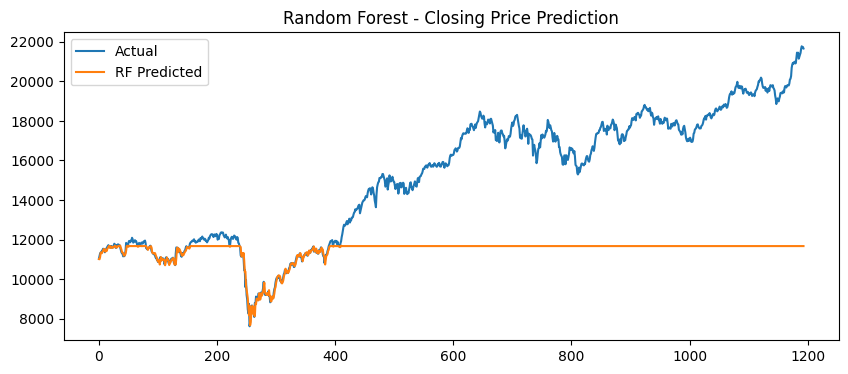

In [141]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='RF Predicted')
plt.title("Random Forest - Closing Price Prediction")
plt.legend()
plt.show()

In [142]:
# Create features for prediction
"""Create technical indicators as features"""
# Simple moving averages
df['SMA5'] = df['Close'].rolling(window=5).mean()
df['SMA20'] = df['Close'].rolling(window=20).mean()
    
# Price difference (Close - Open)
df['Price_Diff'] = df['Close'] - df['Open']
    
# Volatility (High - Low)
df['Volatility'] = df['High'] - df['Low']
    
# Remove rows with NaN values
df.dropna(inplace=True)
    


In [143]:
# Prepare data for Bidirectional RNN
"""Prepare sequential data for Bidirectional RNN"""
sequence_length=10
feature_cols = ['Open', 'High', 'Low', 'SMA5', 'SMA20', 'Price_Diff', 'Volatility']
target_col=['Close']
# Extract features and target
X = df[feature_cols].values
y = df[target_col].values
    
    # Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
    
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Create sequences
X_seq, y_seq = [], []
for i in range(sequence_length, len(X_scaled)):
    X_seq.append(X_scaled[i-sequence_length:i])
    y_seq.append(y_scaled[i])
    
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
    
    # Split data
train_size = int(len(X_seq) * 0.8)
X_train = X_seq[:train_size]
X_test = X_seq[train_size:]
y_train = y_seq[:train_size]
y_test = y_seq[train_size:]
    


In [144]:
# BiRNN input (already in correct 3D shape)
X_train_birnn = X_train
X_test_birnn = X_test

# BiRNN target (flatten to 1D)
y_train_birnn = y_train.reshape(-1)
y_test_birnn = y_test.reshape(-1)


In [145]:
# Build and train Bidirectional RNN model
print("Building BiRNN model...")
birnn_model = Sequential()

# Add Bidirectional LSTM layer
birnn_model.add(Bidirectional(LSTM(50, return_sequences=True), 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
birnn_model.add(Dropout(0.2))

# Add second Bidirectional LSTM layer 
birnn_model.add(Bidirectional(LSTM(30)))
birnn_model.add(Dropout(0.2))

# Add Dense layers
birnn_model.add(Dense(20, activation='relu'))
birnn_model.add(Dense(1))

# Compile the model
birnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
birnn_model.summary()

# Train the model
print("\nTraining BiRNN model...")
history = birnn_model.fit(X_train, y_train,
                   epochs=15,
                   batch_size=60,
                   validation_data=(X_test, y_test),
                   verbose=1)

Building BiRNN model...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_10                │ (None, 10, 100)        │        23,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 60)             │        31,440 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,881 (218.29 KB)

 Trainable params: 55,881 (218.29 KB)

 Non-trainable params: 0 (0.00 B)


Training BiRNN model...
Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0061 - mae: 0.0510 - val_loss: 0.0041 - val_mae: 0.0520
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1267e-04 - mae: 0.0173 - val_loss: 0.0035 - val_mae: 0.0488
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9702e-04 - mae: 0.0159 - val_loss: 0.0022 - val_mae: 0.0382
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8810e-04 - mae: 0.0138 - val_loss: 0.0029 - val_mae: 0.0453
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.3855e-04 - mae: 0.0129 - val_loss: 0.0043 - val_mae: 0.0592
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4113e-04 - mae: 0.0131 - val_loss: 0.0024 - val_mae: 0.0427
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7190e-04 - mae: 0.0117 - val_loss: 0.0028 - val_mae: 0.0466
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6856e-04 - mae: 0.0117 - val_loss: 0.0013 - val_mae: 0.0299
Epoch 9/15
80/80 ━

In [146]:
birnn_preds = birnn_model.predict(X_test)
birnn_mse = mean_squared_error(y_test_birnn, birnn_preds)
birnn_rmse = np.sqrt(birnn_mse)
birnn_mae = mean_absolute_error(y_test_birnn, birnn_preds)
print("\nBi Directional RNN Evaluation: ")
print(f"BiRNN - RMSE: {birnn_rmse:.4f}, MAE: {birnn_mae:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Bi Directional RNN Evaluation: 
BiRNN - RMSE: 0.0372, MAE: 0.0327


In [147]:
"""Plot predictions against actual values"""
# Get the test data timeframe
test_data_size = int(len(df) *0.2)
test_index = df.index[-test_data_size:]

birnn_preds_original = scaler_y.inverse_transform(birnn_preds.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_birnn.reshape(-1, 1)).flatten()


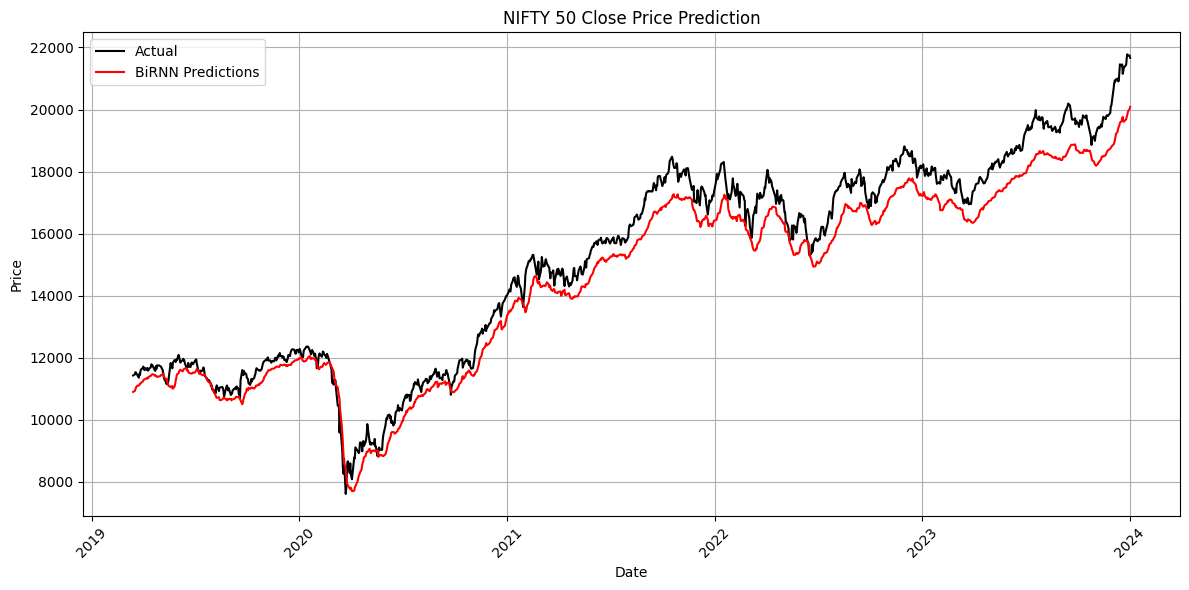

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_index[-len(y_test_birnn):], y_test_original, label='Actual', color='black')
plt.plot(test_index[-len(birnn_preds):], birnn_preds_original, label='BiRNN Predictions', color='red')

plt.title('NIFTY 50 Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()